In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
road = pd.read_csv('/content/drive/MyDrive/data capstone/Road Accident Data 2.csv')

In [ ]:
road.dropna(inplace=True)

In [ ]:
road['Time'].head()

,Time
195,19:00
414,15:55
476,17:36
854,8:35
889,16:10


In [ ]:
#convert time to minutes
road['Time'] = road['Time'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

In [ ]:

road['Time'].iloc[0]

1140

In [ ]:
categorical = road.select_dtypes(include=['object'])
numerical = road.select_dtypes(exclude=['object'])

In [ ]:
numerical.columns

Index(['Year', 'Latitude', 'Longitude', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Speed_limit', 'Time'],
      dtype='object')

In [ ]:
target = road['Accident_Severity']
categorical = categorical.drop('Accident_Severity', axis=1)

In [ ]:
categorical.drop('Accident_Index',axis= 1, inplace = True)
categorical.drop('Accident Date', axis=1, inplace=True)
#categorical.drop('Time', axis=1, inplace=True)
categorical.drop('Local_Authority_(District)', axis=1, inplace=True)
categorical.drop('Police_Force', axis=1, inplace=True)

In [ ]:
categorical.columns

Index(['Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail',
       'Light_Conditions', 'Carriageway_Hazards', 'Road_Surface_Conditions',
       'Road_Type', 'Urban_or_Rural_Area', 'Weather_Conditions',
       'Vehicle_Type'],
      dtype='object')

In [ ]:
numerical.columns

Index(['Year', 'Latitude', 'Longitude', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Speed_limit', 'Time'],
      dtype='object')

In [ ]:
categorical = pd.get_dummies(categorical, drop_first=True)
categorical = categorical.astype(int)

In [ ]:
target = target.map({'Slight': 0, 'Serious': 1, 'Fatal': 2})

In [ ]:
df = pd.concat([categorical,numerical,target], axis=1)

In [ ]:
target = df['Accident_Severity']
predictors = df.drop('Accident_Severity', axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3, random_state=42)

In [ ]:
StandardScaler = StandardScaler()
x_train[numerical.columns] = StandardScaler.fit_transform(x_train[numerical.columns])

In [ ]:
y_train.value_counts()

,count
Accident_Severity,
0,3116
1,546
2,51


In [ ]:
sm = SMOTE(
    sampling_strategy='auto',
    random_state=42,
    k_neighbors=5,
)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [ ]:
x_train.shape, x_train_res.shape

((3713, 74), (9348, 74))

In [ ]:
numerical1 = x_train_res[numerical.columns]

In [ ]:
categorical1 = x_train_res.drop(numerical.columns, axis=1)

In [ ]:
target1 = y_train_res

In [ ]:
train_df = pd.concat([categorical1,numerical1,target1], axis=1)

In [ ]:
mean = train_df[numerical.columns].mean()
std = train_df[numerical.columns].std()

In [ ]:
train_df[numerical.columns] = (train_df[numerical.columns] - mean) / std

In [ ]:
x_test[numerical.columns] = (x_test[numerical.columns] - mean) / std

In [ ]:
df1 = train_df

In [ ]:
target = y_train_res
predictors = df1.drop('Accident_Severity', axis=1)

In [ ]:
predictors.shape, target.shape

((9348, 74), (9348,))

random forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, max_features='sqrt', min_samples_leaf=5, min_samples_split=10)

In [ ]:
rf.fit(predictors,target)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [ ]:
rf_pred = rf.predict(x_test)

In [ ]:
rf_acc = accuracy_score(y_test, rf_pred)
rf_acc

0.8084170854271356

<Axes: xlabel='Predicted', ylabel='Actual'>

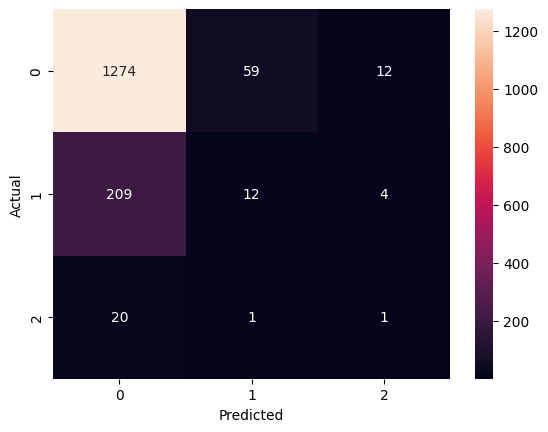

In [ ]:
sns.heatmap(pd.crosstab(y_test, rf_pred, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')

In [ ]:
#random forest variable importance
importances = rf.feature_importances_

In [ ]:
#show all columns
pd.set_option('display.max_columns', None)

In [ ]:
#show importances with variable names
feature_importances = pd.DataFrame(importances, index=predictors.columns, columns=['Importance'])
feature_importances.sort_values('Importance', ascending=False)

,Importance
Speed_limit,0.110598
Time,0.095918
Road_Type_Single carriageway,0.075777
Year,0.058574
Urban_or_Rural_Area_Urban,0.053496
...,...
Weather_Conditions_Snowing + high winds,0.000000
Vehicle_Type_Goods over 3.5t. and under 7.5t,0.000000
Vehicle_Type_Pedal cycle,0.000000
Vehicle_Type_Minibus (8 - 16 passenger seats),0.000000


ordinal logistic AT

In [ ]:
pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=82de2c2b864f20ddf6d3ff67504fd4c30b3b48c7db6dfcd9b08508eb512563e5
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [ ]:
import mord

In [ ]:
at_model = mord.LogisticAT(alpha=0)

In [ ]:
at_model.fit(predictors, target)

LogisticAT(alpha=0)

In [ ]:
at_model_pred = at_model.predict(x_test)

In [ ]:
at_model_acc = accuracy_score(y_test, at_model_pred)
at_model_acc

0.7594221105527639

(1592,)

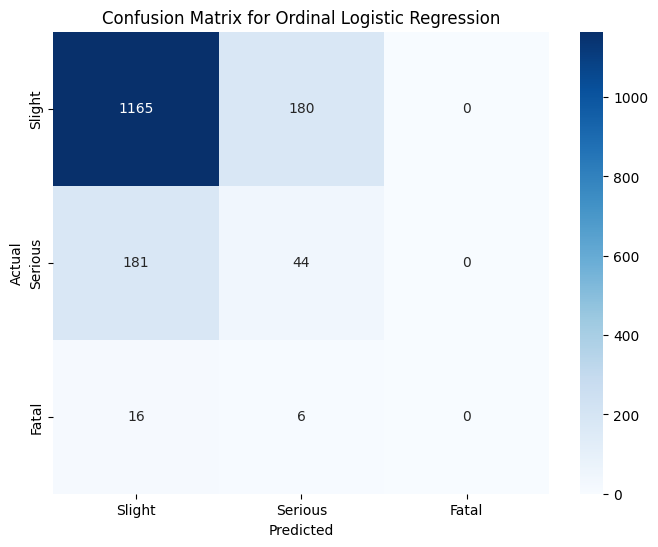

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, at_model_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Slight', 'Serious', 'Fatal'],
            yticklabels=['Slight', 'Serious', 'Fatal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Ordinal Logistic Regression')
plt.show()


<Axes: >

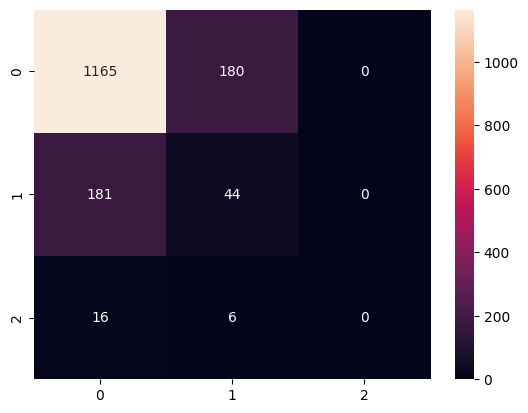

In [ ]:
#confusion matrix for at model
sns.heatmap(confusion_matrix(y_test, at_model_pred), annot=True, fmt='d')

multinomial logistic

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)

In [ ]:
logreg.fit(predictors, target)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

In [ ]:
logreg_pred = logreg.predict(x_test)

In [ ]:
logreg_acc = accuracy_score(y_test, logreg_pred)
logreg_acc

0.8096733668341709

<Axes: xlabel='Predicted', ylabel='Actual'>

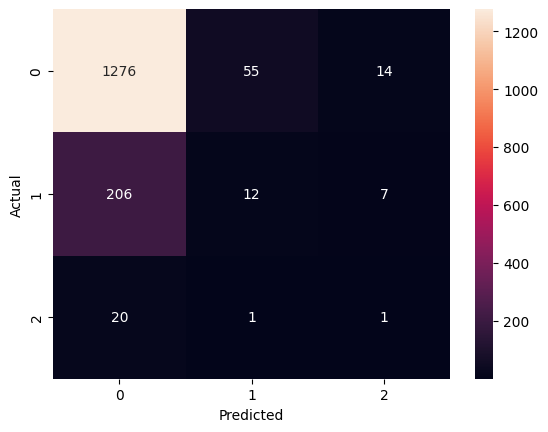

In [ ]:
sns.heatmap(pd.crosstab(y_test, logreg_pred, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')

neural network

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(128, input_shape=(predictors.shape[1],), activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.fit(predictors, target, epochs=25, validation_split=0.2)

Epoch 1/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6214 - loss: 0.8109 - val_accuracy: 0.5936 - val_loss: 0.7669
Epoch 2/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8163 - loss: 0.4759 - val_accuracy: 0.7733 - val_loss: 0.4487
Epoch 3/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8399 - loss: 0.4112 - val_accuracy: 0.7984 - val_loss: 0.4362
Epoch 4/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8618 - loss: 0.3628 - val_accuracy: 0.9102 - val_loss: 0.2683
Epoch 5/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8746 - loss: 0.3297 - val_accuracy: 0.8080 - val_loss: 0.3881
Epoch 6/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8934 - loss: 0.2897 - val_accuracy: 0.9246 - val_loss: 0.2061
Epoch 7/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8893 - loss: 0.2879 - val_accuracy: 0.8754 - val_loss: 0.2777
Epoch 8/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9027 - loss: 0.2505 - val_accuracy: 0

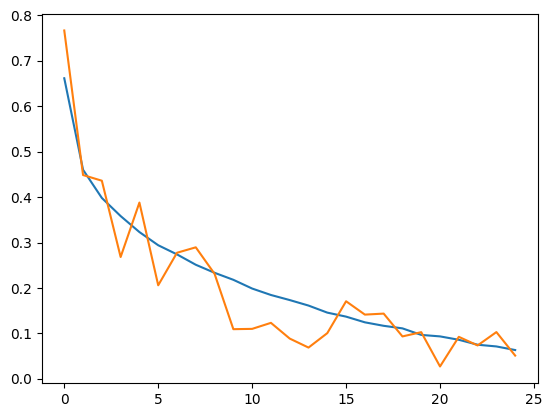

In [ ]:
#plot the losses
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [ ]:
model_preds = model.predict(x_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
#model accuracy
model_acc = accuracy_score(y_test, np.argmax(model_preds, axis=1))
model_acc

0.7644472361809045

<Axes: xlabel='Predicted', ylabel='Actual'>

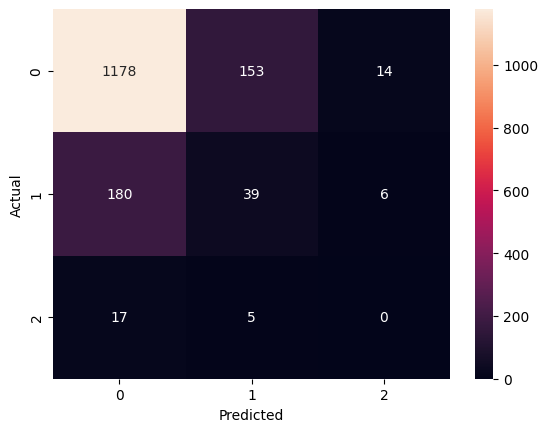

In [ ]:
#confusion matrix
sns.heatmap(pd.crosstab(y_test, np.argmax(model_preds, axis=1), rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')

GBM























In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

In [ ]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [ ]:
gbm.fit(predictors, target)

GradientBoostingClassifier(random_state=42)

In [ ]:
gbm_pred = gbm.predict(x_test)

In [ ]:
gbm_acc = accuracy_score(y_test, gbm_pred)
gbm_acc

0.7782663316582915

<Axes: xlabel='Predicted', ylabel='Actual'>

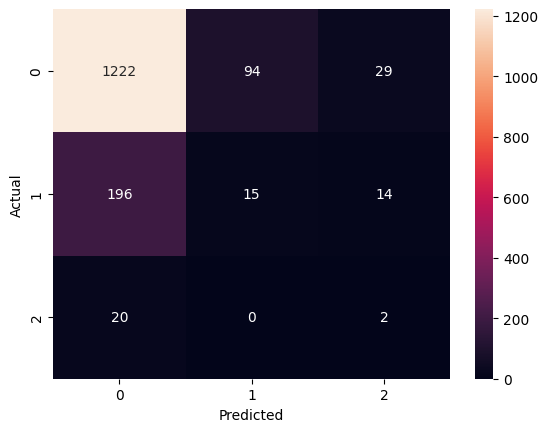

In [ ]:
sns.heatmap(pd.crosstab(y_test, gbm_pred, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')

**BAYESIAN NEURAL NETWORKS**

In [ ]:
!pip install tensorflow==2.12.0
!pip install tensorflow_probability==0.20.1

  Using cached tensorflow_probability-0.20.1-py2.py3-none-any.whl.metadata (13 kB)
Using cached tensorflow_probability-0.20.1-py2.py3-none-any.whl (6.9 MB)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import tensorflow_probability as tfp

In [ ]:
def nll(y_true, y_pred):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

In [ ]:
# Define the prior normal - using mean=0 and stddev=1
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

# Define posterior function, which adjusts normal parameters during training
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            # Parameterize the mean and log-variance for each weight and bias
            tfp.layers.VariableLayer(2 * n, dtype=dtype),  # 2*n for mean and log-variance
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.Independent(
                    tfp.distributions.Normal(
                        loc=t[..., :n],                     # First n values are means
                        scale=tf.math.softplus(t[..., n:])  # Remaining n values are stddevs
                    ),
                    reinterpreted_batch_ndims=1  # Treat weights as a vector distribution
                )
            ),
        ]
    )
    return posterior_model

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input( shape=((predictors.shape[1]),) )

hidden1 = tfp.layers.DenseVariational(units=32,
                                      make_prior_fn=prior,
                                      make_posterior_fn=posterior,
                                      kl_weight=1/predictors.shape[0], # 1/train_size
                                      activation='sigmoid')(inputs)

hidden2 = tfp.layers.DenseVariational(units=25,
                                      make_prior_fn=prior,
                                      make_posterior_fn=posterior,
                                      kl_weight=1/predictors.shape[0], # 1/train_size
                                      activation='sigmoid')(hidden1)
hidden3 = tfp.layers.DenseVariational(units=16,
                                      make_prior_fn=prior,
                                      make_posterior_fn=posterior,
                                      kl_weight=1/predictors.shape[0], # 1/train_size
                                      activation='sigmoid')(hidden2)
distribution_params = keras.layers.Dense(units=3)(hidden3)
output = tfp.layers.OneHotCategorical(3)(distribution_params)

bnn = keras.Model(inputs=inputs, outputs=output)
bnn.compile(loss=nll, optimizer=keras.optimizers.RMSprop(learning_rate=0.01), metrics=['accuracy'])

bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 74)]              0         
                                                                 
 dense_variational (DenseVar  (None, 32)               4800      
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 25)               1650      
 ariational)                                                     
                                                                 
 dense_variational_2 (DenseV  (None, 16)               832       
 ariational)                                                     
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                             

**DenseVariational** creates a layer that learns a distribution over its weights, which is the core concept of Bayesian neural networks.
<br>**make_prior_fn=prior** and **make_posterior_fn=posterior** are functions that define the prior and posterior distributions over the weights, respectively. They provide a way to incorporate prior knowledge and update beliefs about the weights during training.
<br> **tfp.layers.OneHotCategorical(3)** converts the logits into a categorical distribution with 3 categories. This layer ensures that the output of the network is a probability distribution over the classes.

In [ ]:
run = bnn.fit(predictors,target,batch_size=32, epochs=150,verbose = 1)

Epoch 1/150
293/293 [==============================] - 3s 3ms/step - loss: 4.0767 - accuracy: 0.3329
Epoch 2/150
293/293 [==============================] - 1s 3ms/step - loss: 3.7248 - accuracy: 0.3304
Epoch 3/150
293/293 [==============================] - 1s 2ms/step - loss: 3.4506 - accuracy: 0.3322
Epoch 4/150
293/293 [==============================] - 1s 4ms/step - loss: 3.3598 - accuracy: 0.3409
Epoch 5/150
293/293 [==============================] - 1s 4ms/step - loss: 3.3276 - accuracy: 0.3308
Epoch 6/150
293/293 [==============================] - 1s 4ms/step - loss: 3.3188 - accuracy: 0.3369
Epoch 7/150
293/293 [==============================] - 1s 3ms/step - loss: 3.3163 - accuracy: 0.3402
Epoch 8/150
293/293 [==============================] - 1s 2ms/step - loss: 3.3162 - accuracy: 0.3315
Epoch 9/150
293/293 [==============================] - 1s 3ms/step - loss: 3.3169 - accuracy: 0.3286
Epoch 10/150
293/293 [==============================] - 1s 3ms/step - loss: 3.3172 - accura

In [ ]:
import numpy as np

num_samples = 100
# Each prediction is a tfd.OneHotCategorical distribution
# Convert x_test to a NumPy array before passing it to the model
predictive_distributions = [bnn(x_test.values) for _ in range(num_samples)]

# Step 1: Convert to probability vectors (batch_size x 3)
probs = np.array([dist.probs_parameter().numpy() for dist in predictive_distributions])

# Step 2: Mean probability vector (predictive distribution)
mean_probs = np.mean(probs, axis=0)

# Step 3: Predictive entropy (total uncertainty)
def entropy(p):
    return -np.sum(p * np.log(p + 1e-10), axis=-1)

total_uncertainty = entropy(mean_probs)

# Step 4: Expected entropy (aleatoric uncertainty)
individual_entropies = entropy(probs)
aleatoric_uncertainty = np.mean(individual_entropies, axis=0)

# Step 5: Epistemic = Total - Aleatoric
epistemic_uncertainty = total_uncertainty - aleatoric_uncertainty

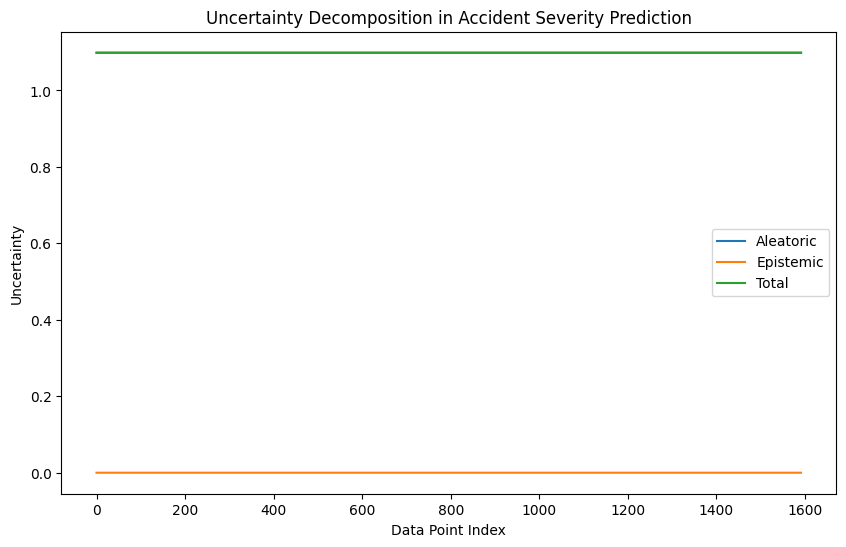

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(aleatoric_uncertainty, label="Aleatoric")
plt.plot(epistemic_uncertainty, label="Epistemic")
plt.plot(total_uncertainty, label="Total")
plt.xlabel("Data Point Index")
plt.ylabel("Uncertainty")
plt.title("Uncertainty Decomposition in Accident Severity Prediction")
plt.legend()
plt.show()

**PROBABILISTIC NEURAL NETWORK**

In [ ]:
# Build the PNN model
inputs = tf.keras.layers.Input(shape=(predictors.shape[1],))

hidden1 = keras.layers.Dense(units=68, activation='relu')(inputs)
hidden2 = keras.layers.Dense(units=32, activation='relu')(hidden1)

# Output layer predicts logits for 3 classes (no activation)
distribution_params = keras.layers.Dense(units=3)(hidden2)

# Categorical distribution from logits
# Removed num_classes and kept event_size=1
output = tfp.layers.OneHotCategorical(event_size=1)(distribution_params)

# Build the model
pnn = keras.Model(inputs=inputs, outputs=output)
pnn.compile(loss=nll, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

pnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 74)]              0         
                                                                 
 dense_12 (Dense)            (None, 68)                5100      
                                                                 
 dense_13 (Dense)            (None, 32)                2208      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
 one_hot_categorical_2 (OneH  ((None, 3),              0         
 otCategorical)               (None, 3))                         
                                                                 
Total params: 7,407
Trainable params: 7,407
Non-trainable params: 0
_________________________________________________________

In [ ]:
keras.backend.clear_session()

In [ ]:
p_run = pnn.fit(predictors,target,batch_size=32, epochs=150,verbose = 1)

Epoch 1/150
293/293 [==============================] - 2s 5ms/step - loss: 3781.9863 - accuracy: 0.3214
Epoch 2/150
293/293 [==============================] - 1s 2ms/step - loss: 3402.6350 - accuracy: 0.3360
Epoch 3/150
293/293 [==============================] - 1s 2ms/step - loss: 3018.1365 - accuracy: 0.3356
Epoch 4/150
293/293 [==============================] - 1s 2ms/step - loss: 2703.6003 - accuracy: 0.3379
Epoch 5/150
293/293 [==============================] - 1s 2ms/step - loss: 3228.8291 - accuracy: 0.3337
Epoch 6/150
293/293 [==============================] - 1s 2ms/step - loss: 2756.7539 - accuracy: 0.3352
Epoch 7/150
293/293 [==============================] - 1s 2ms/step - loss: 3047.5701 - accuracy: 0.3401
Epoch 8/150
293/293 [==============================] - 1s 3ms/step - loss: 2865.7192 - accuracy: 0.3308
Epoch 9/150
293/293 [==============================] - 1s 3ms/step - loss: 2824.9214 - accuracy: 0.3366
Epoch 10/150
293/293 [==============================] - 1s 3ms/s

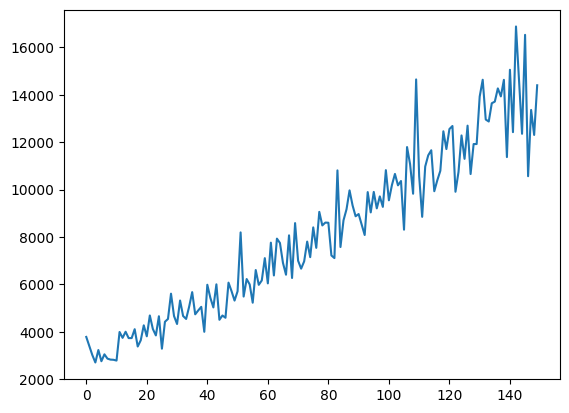

In [ ]:
#plot losses
plt.plot(p_run.history['loss'])